In [1]:
import os
import glob
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Define your data directories
TRAIN_DIR = '/kaggle/input/instant-odc-ai-hackathon/Train'
TEST_DIR = '/kaggle/input/instant-odc-ai-hackathon/test' # Adjust if capitalization differs (e.g. 'Test')

# --- 1. Z-Score Normalization Helper ---
def normalize_volume(vol):
    """
    Normalizes the volume per-channel using Z-score standardization.
    Formula: (x - mean) / std
    We compute statistics only on non-zero pixels (the brain region) to avoid background bias.
    """
    # vol shape: (H, W, D, 4)
    vol_norm = np.zeros_like(vol)
    
    for c in range(4): # Loop through T1, T1ce, T2, FLAIR
        channel = vol[:, :, :, c]
        
        # Calculate stats on non-zero pixels only (the brain)
        mask_brain = channel > 0
        if np.sum(mask_brain) > 0:
            mean = np.mean(channel[mask_brain])
            std = np.std(channel[mask_brain])
            
            # Apply Z-score
            # We verify std != 0 to avoid division by zero
            if std > 0:
                vol_norm[:, :, :, c] = (channel - mean) / std
                
                # Optional: Clip outliers (e.g., between -5 and 5) to stabilize training
                # vol_norm[:, :, :, c] = np.clip(vol_norm[:, :, :, c], -5, 5)
            else:
                vol_norm[:, :, :, c] = channel # Keep as is if flat
        else:
            vol_norm[:, :, :, c] = channel
            
    return vol_norm

def load_case(case_id, root_dir, normalize=True):
    path = os.path.join(root_dir, case_id)

    # Helper to find file paths
    def get_path(pattern):
        matches = glob.glob(os.path.join(path, f"*{pattern}*"))
        if not matches:
            matches = glob.glob(os.path.join(path, f"*{pattern}*"))
            if not matches:
                 raise FileNotFoundError(f"Could not find file with pattern '{pattern}' in {path}")
        return matches[0]

    # Load file paths
    flair_path = get_path("flair")
    t1ce_path = get_path("t1ce") 
    t2_path   = get_path("t2")
    seg_path  = get_path("seg")
    
    # Special handling for T1
    all_t1 = glob.glob(os.path.join(path, "*t1*"))
    t1_path = [p for p in all_t1 if "t1ce" not in p][0]

    # Load Data
    flair_img = nib.load(flair_path)
    affine = flair_img.affine 
    
    flair = flair_img.get_fdata()
    t1    = nib.load(t1_path).get_fdata()
    t1ce  = nib.load(t1ce_path).get_fdata()
    t2    = nib.load(t2_path).get_fdata()
    seg   = nib.load(seg_path).get_fdata()

    # Stack modalities
    X = np.stack([flair, t1, t1ce, t2], axis=-1)
    
    # Normalize if requested
    if normalize:
        X = normalize_volume(X)
    
    # Map 4 -> 3
    seg[seg == 4] = 3
    
    return X, seg, affine


In [2]:
def seed_everything(SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_default_device():
    gpu_available = torch.cuda.is_available()
    return torch.device('cuda' if gpu_available else 'cpu'), gpu_available

In [3]:
import os
import random
from tqdm import tqdm
import nibabel as nib
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import shutil
import time

from dataclasses import dataclass
import gc


import torch
import torch.nn as nn
import torch.nn.functional as F


In [4]:
def analyze_class_balance(mask, patient_id):
    """
    Prints a detailed breakdown of the number of voxels and percentage 
    for each tumor sub-region.
    """
    # Define the mapping based on the Hackathon rules (Label 4 mapped to 3)
    class_names = {
        0: "Background",
        1: "Necrotic Core",
        2: "Edema",
        3: "Enhancing Tumor"
    }
    
    total_voxels = mask.size
    
    print(f"Class Imbalance Analysis for {patient_id}:")
    
    # Iterate through all 4 classes (0, 1, 2, 3)
    for label_idx, name in class_names.items():
        count = np.sum(mask == label_idx)
        percentage = (count / total_voxels) * 100
        
        # Format with commas for thousands and 4 decimal places for percent
        print(f"   Label {label_idx} ({name}): {count:,} voxels ({percentage:.4f}%)")

In [5]:
# Load the NIfTI image
sample_image_flair = nib.load(os.path.join("/kaggle/input/instant-odc-ai-hackathon/Train/BraTS2021_00003/BraTS2021_00003_flair.nii/00000017_brain_flair.nii")).get_fdata()
print("Original max value:", sample_image_flair.max())

# Reshape the 3D image to 2D for scaling
sample_image_flair_flat = sample_image_flair.reshape(-1, 1)

Original max value: 3164.0


In [6]:
sample_mask = nib.load("/kaggle/input/instant-odc-ai-hackathon/Train/BraTS2021_00003/BraTS2021_00003_seg.nii/BraTS2021_00003_seg_new.nii").get_fdata()
sample_mask = sample_mask.astype(np.uint8) 

print("Unique classes in the mask", np.unique(sample_mask))
print("Shape of mask: ", sample_mask.shape)

Unique classes in the mask [0 1 2 4]
Shape of mask:  (240, 240, 155)


In [7]:
from sklearn.preprocessing import MinMaxScaler

# Apply scaling
scaler = MinMaxScaler()

sample_image_flair_scaled = scaler.fit_transform(sample_image_flair_flat)

# Reshape it back to the original 3D shape
sample_image_flair_scaled = sample_image_flair_scaled.reshape(sample_image_flair.shape)

print("Scaled max value:", sample_image_flair_scaled.max())
print("Shape of scaled Image: ", sample_image_flair_scaled.shape)
sample_image_t1 = nib.load('/kaggle/input/instant-odc-ai-hackathon/Train/BraTS2021_00003/BraTS2021_00003_t1.nii/00000017_brain_t1.nii').get_fdata()
sample_image_t1 = scaler.fit_transform(sample_image_t1.reshape(-1,sample_image_t1.shape[-1])).reshape(sample_image_t1.shape)
sample_image_t1.shape
sample_image_t1ce = nib.load('/kaggle/input/instant-odc-ai-hackathon/Train/BraTS2021_00003/BraTS2021_00003_t1ce.nii/00000017_brain_t1ce.nii').get_fdata()
sample_image_t1ce = scaler.fit_transform(sample_image_t1ce.reshape(-1,sample_image_t1ce.shape[-1])).reshape(sample_image_t1ce.shape)
sample_image_t1ce.shape
sample_image_t2 = nib.load('/kaggle/input/instant-odc-ai-hackathon/Train/BraTS2021_00003/BraTS2021_00003_t2.nii/00000017_brain_t2.nii').get_fdata()
sample_image_t2 = scaler.fit_transform(sample_image_t2.reshape(-1,sample_image_t2.shape[-1])).reshape(sample_image_t2.shape)
sample_image_t2.shape

Scaled max value: 1.0
Shape of scaled Image:  (240, 240, 155)


(240, 240, 155)

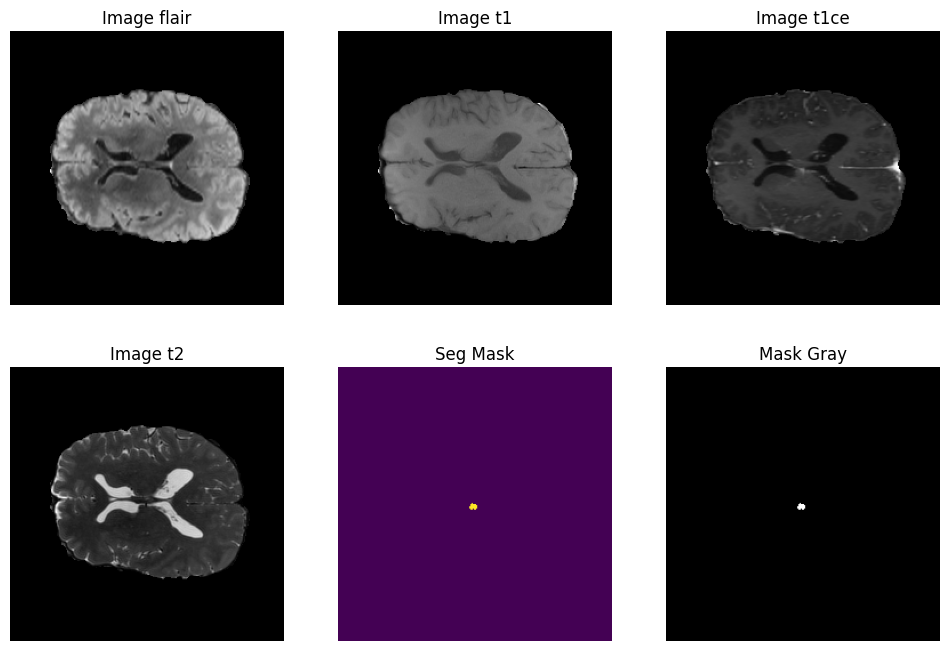

In [8]:
n_slice = 77

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(sample_image_flair_scaled[:, :, n_slice], cmap='gray')
plt.title('Image flair')
plt.axis('off')  # Remove axis

plt.subplot(232)
plt.imshow(sample_image_t1[:, :, n_slice], cmap='gray')
plt.title("Image t1")
plt.axis('off')  # Remove axis

plt.subplot(233)
plt.imshow(sample_image_t1ce[:, :, n_slice], cmap='gray')
plt.title("Image t1ce")
plt.axis('off')  # Remove axis

plt.subplot(234)
plt.imshow(sample_image_t2[:, :, n_slice], cmap='gray')
plt.title("Image t2")
plt.axis('off')  # Remove axis

plt.subplot(235)
plt.imshow(sample_mask[:, :, n_slice])
plt.title("Seg Mask")
plt.axis('off')  # Remove axis

plt.subplot(236)
plt.imshow(sample_mask[:, :, n_slice], cmap='gray')
plt.title('Mask Gray')
plt.axis('off')  # Remove axis

# Save without padding and axes
plt.savefig("gt_plot.png", bbox_inches='tight', pad_inches=0)
plt.show()


In [9]:
combined_x = np.stack([sample_image_flair_scaled, sample_image_t1ce, sample_image_t2], axis = 3) 
print("Shape of Combined x ", combined_x.shape)

Shape of Combined x  (240, 240, 155, 3)


In [10]:
combined_x = combined_x[56:184, 56:184, 13:141]
print("Shape after cropping: ", combined_x.shape)

sample_mask_c = sample_mask[56:184,56:184, 13:141]
print("Mask shape after cropping: ", sample_mask_c.shape)

# Assuming sample_mask_ is a NumPy array
size_in_bytes = sample_mask_c.nbytes
size_in_mb = size_in_bytes / (1024 ** 2)  # Convert from bytes to megabytes
print("\n")
print(f"Size of sample_mask_ in MB: {size_in_mb:.2f} MB")

Shape after cropping:  (128, 128, 128, 3)
Mask shape after cropping:  (128, 128, 128)


Size of sample_mask_ in MB: 2.00 MB


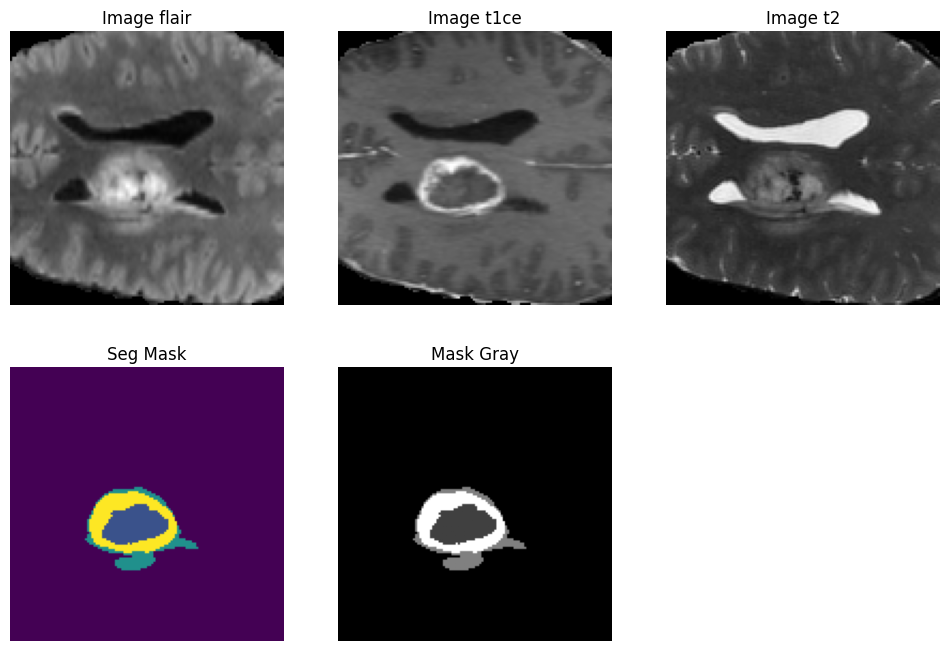

In [11]:
import matplotlib.pyplot as plt
import random

# Randomly select a slice
n_slice = 75 # Ensure slice is within valid range

plt.figure(figsize=(12, 8))

# Display 'Image flair'
plt.subplot(231)
plt.imshow(combined_x[:, :, n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.axis('off')  # Remove axis

# Display 'Image t1ce'
plt.subplot(232)
plt.imshow(combined_x[:, :, n_slice, 1], cmap='gray')
plt.title("Image t1ce")
plt.axis('off')  # Remove axis

# Display 'Image t2'
plt.subplot(233)
plt.imshow(combined_x[:, :, n_slice, 2], cmap='gray')
plt.title("Image t2")
plt.axis('off')  # Remove axis

# Display segmentation mask without gray scale
plt.subplot(234)
plt.imshow(sample_mask_c[:, :, n_slice])
plt.title("Seg Mask")
plt.axis('off')  # Remove axis

# Display segmentation mask in gray scale
plt.subplot(235)
plt.imshow(sample_mask_c[:, :, n_slice], cmap='gray')
plt.title('Mask Gray')
plt.axis('off')  # Remove axis

# Save the figure without padding and axes
plt.savefig("gt_plot.png", bbox_inches='tight', pad_inches=0)
plt.show()


In [12]:
os.makedirs("cropped_data", exist_ok = True)
np.save("cropped_data/combined255.npy", combined_x)

Dataset Statistics:
-------------------
Total Train Patients: 917
Total Test Patients:  334
-------------------
Analyzing Case: BraTS2021_01030...


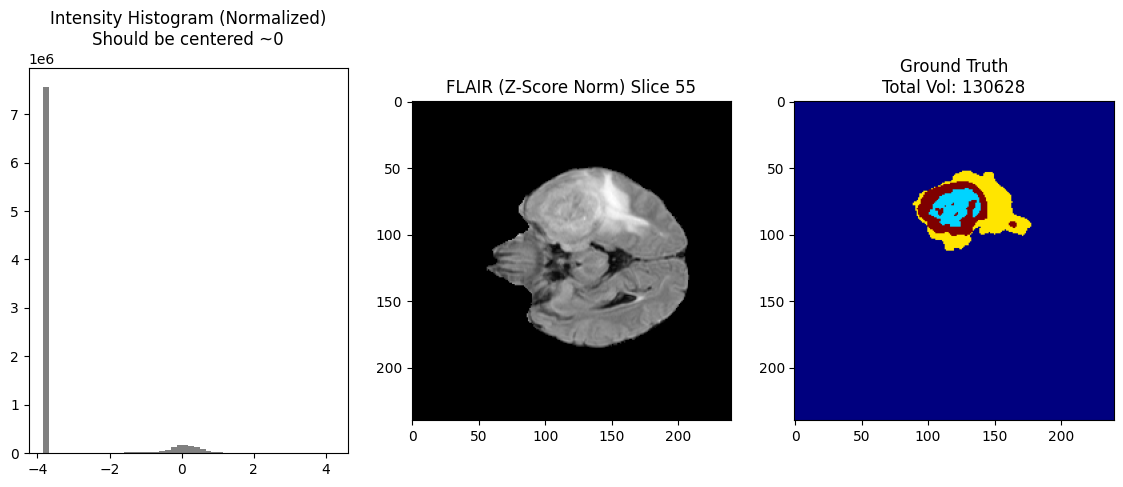

Class Imbalance Analysis for BraTS2021_01030:
   Label 0 (Background): 8,797,372 voxels (98.5369%)
   Label 1 (Necrotic Core): 11,764 voxels (0.1318%)
   Label 2 (Edema): 65,273 voxels (0.7311%)
   Label 3 (Enhancing Tumor): 53,591 voxels (0.6003%)
Affine Matrix:  [[ -1.  -0.  -0.  -0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]


In [13]:
# --- 2. Data Statistics & Tumor Analysis ---
try:
    # A. Count Patients
    train_ids = [d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]
    # Check if test dir exists before counting
    if os.path.exists(TEST_DIR):
        test_ids = [d for d in os.listdir(TEST_DIR) if os.path.isdir(os.path.join(TEST_DIR, d))]
    else:
        test_ids = []
        
    print(f"Dataset Statistics:")
    print(f"-------------------")
    print(f"Total Train Patients: {len(train_ids)}")
    print(f"Total Test Patients:  {len(test_ids)}")
    print(f"-------------------")

    # B. Load One Normalized Case
    example_id = train_ids[0]
    print(f"Analyzing Case: {example_id}...")
    X, y, affine = load_case(example_id, TRAIN_DIR, normalize=True)
    
    # C. Tumor Size Calculation
    # Voxel count per class
    ncr_count = np.sum(y == 1) # Necrotic
    ed_count  = np.sum(y == 2) # Edema
    et_count  = np.sum(y == 3) # Enhancing (was 4)
    total_tumor = ncr_count + ed_count + et_count
    

    # Visualization with stats
    slice_idx = np.argmax(np.sum(y > 0, axis=(0, 1)))
    
    plt.figure(figsize=(14, 5))
    
    # Histogram of Intensity (Proof of Normalization)
    plt.subplot(1, 3, 1)
    # Flatten just the brain part for the histogram
    brain_pixels = X[X[:,:,:,0] != 0, 0] 
    plt.hist(brain_pixels, bins=50, color='gray')
    plt.title("Intensity Histogram (Normalized)\nShould be centered ~0")
    
    plt.subplot(1, 3, 2)
    plt.imshow(X[:, :, slice_idx, 0], cmap='gray')
    plt.title(f"FLAIR (Z-Score Norm) Slice {slice_idx}")

    plt.subplot(1, 3, 3)
    plt.imshow(y[:, :, slice_idx], cmap='jet')
    plt.title(f"Ground Truth\nTotal Vol: {total_tumor}")
    
    plt.show()

except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()
analyze_class_balance(y, example_id)
print(f"Affine Matrix:  {affine}")


In [14]:
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom, gaussian_filter
import scipy

def normalize_volume_zscore(vol, clip=(-5, 5)):
    """
    Per-modality Z-score over non-zero (brain) voxels, clip outliers.
    vol: (H,W,D,C)
    """
    out = np.zeros_like(vol, dtype=np.float32)
    for c in range(vol.shape[-1]):
        channel = vol[..., c]
        mask = channel != 0
        if np.any(mask):
            m = channel[mask].mean()
            s = channel[mask].std()
            if s <= 0:
                out[..., c] = channel
            else:
                z = (channel - m) / s
                if clip is not None:
                    z = np.clip(z, clip[0], clip[1])
                out[..., c] = z
        else:
            out[..., c] = channel
    return out

def get_brain_bbox(volume, margin=8):
    """Return tight bbox around non‑zero with optional margin."""
    mask = np.any(volume != 0, axis=-1)
    coords = np.array(np.where(mask))
    if coords.size == 0:
        # fallback full volume
        return (0, volume.shape[0], 0, volume.shape[1], 0, volume.shape[2])
    mins = coords.min(axis=1)
    maxs = coords.max(axis=1) + 1
    x0 = max(0, mins[0] - margin)
    x1 = min(volume.shape[0], maxs[0] + margin)
    y0 = max(0, mins[1] - margin)
    y1 = min(volume.shape[1], maxs[1] + margin)
    z0 = max(0, mins[2] - margin)
    z1 = min(volume.shape[2], maxs[2] + margin)
    return (x0, x1, y0, y1, z0, z1)

def crop_to_bbox(vol, bbox):
    x0,x1,y0,y1,z0,z1 = bbox
    return vol[x0:x1, y0:y1, z0:z1, ...]

def resample_volume(img, target_spacing=(1.0,1.0,1.0)):
    """
    Resample NIfTI image to isotropic spacing. Use nibabel to read affine.
    Returns numpy array and new affine.
    NOTE: Optional; only use if input spacing differs across cases.
    """
    data = img.get_fdata()
    affine = img.affine
    # compute current spacing from affine diagonal (approx)
    sx = np.linalg.norm(affine[:3,0])
    sy = np.linalg.norm(affine[:3,1])
    sz = np.linalg.norm(affine[:3,2])
    current = (sx, sy, sz)
    zooms = tuple(cs/ts for cs, ts in zip(current, target_spacing))
    data_res = zoom(data, zoom=zooms, order=1)  # linear
    # recompute affine roughly (not exact)
    new_affine = np.copy(affine)
    new_affine[:3,0] = affine[:3,0] / zooms[0]
    new_affine[:3,1] = affine[:3,1] / zooms[1]
    new_affine[:3,2] = affine[:3,2] / zooms[2]
    return data_res, new_affine

# Label remapping helper
def remap_labels(mask):
    """
    Input ground truth contains {0,1,2,4}. We remap 4->3 in internal representation
    so classes = [0,1,2,3] where 3 corresponds to "4" in original GT.
    """
    m = mask.copy()
    m[m == 4] = 3
    return m.astype(np.uint8)

In [15]:
import numpy as np
from scipy.ndimage import rotate, zoom, gaussian_filter

def random_flip(vol, mask):
    if np.random.rand() < 0.5:
        vol = vol[::-1, ...]
        mask = mask[::-1, ...]
    if np.random.rand() < 0.5:
        vol = vol[:, ::-1, ...]
        mask = mask[:, ::-1, ...]
    if np.random.rand() < 0.5:
        vol = vol[:, :, ::-1, ...]
        mask = mask[:, :, ::-1]
    return vol, mask

def random_rotate_90(vol, mask):
    # rotate by multiple of 90 deg in XY plane
    k = np.random.randint(0, 4)
    if k:
        vol = np.rot90(vol, k=k, axes=(0,1)).copy()
        mask = np.rot90(mask, k=k, axes=(0,1)).copy()
    return vol, mask

def random_intensity_scaling(vol, scale_range=(0.9, 1.1), shift_range=(-0.1,0.1)):
    for c in range(vol.shape[-1]):
        if np.random.rand() < 0.5:
            vol[..., c] = vol[..., c] * np.random.uniform(*scale_range) + np.random.uniform(*shift_range)
    return vol

def random_noise(vol, sigma=0.01):
    if np.random.rand() < 0.15:
        vol = vol + np.random.normal(0, sigma, size=vol.shape).astype(vol.dtype)
    return vol

def simple_bias_field(vol, coeff=0.5):
    # small multiplicative low-frequency field
    if np.random.rand() < 0.15:
        shape = vol.shape[:3]
        grid = np.zeros(shape)
        # create a low-freq random field
        rng = np.random.RandomState(None)
        field = gaussian_filter(rng.normal(size=shape), sigma=np.random.uniform(20,50))
        field = (field - field.min()) / (field.max() - field.min())
        field = 1.0 + (field - 0.5) * coeff
        vol = vol * field[..., None]
    return vol

def augment(vol, mask):
    # order is important (spatial transforms then intensity)
    if np.random.rand() < 0.8:
        vol, mask = random_flip(vol, mask)
    if np.random.rand() < 0.5:
        vol, mask = random_rotate_90(vol, mask)
    vol = random_intensity_scaling(vol)
    vol = random_noise(vol)
    vol = simple_bias_field(vol)
    return vol, mask

In [16]:
import glob
import os

# Initial globbing
BASE_PATH = '/kaggle/input/instant-odc-ai-hackathon/Train'
t1ce_list = sorted(glob.glob(f"{BASE_PATH}/*/*t1ce.nii"))
t2_list = sorted(glob.glob(f"{BASE_PATH}/*/*t2.nii"))
t1_list = sorted(glob.glob(f"{BASE_PATH}/*/*t1.nii"))
flair_list = sorted(glob.glob(f"{BASE_PATH}/*/*flair.nii"))
mask_list = sorted(glob.glob(f"{BASE_PATH}/*/*seg.nii"))

def get_clean_lists(t1ce, t2, t1, flair, mask):
    c_t1ce, c_t2, c_t1, c_flair, c_mask = [], [], [], [], []
    print("Filtering out empty files...")
    for i in range(len(t1ce)):
        # Check all 5 files for integrity
        files = [t1ce[i], t2[i], t1[i], flair[i], mask[i]]
        if all(os.path.exists(f) and os.path.getsize(f) > 0 for f in files):
            c_t1ce.append(t1ce[i]); c_t2.append(t2[i]); c_t1.append(t1[i])
            c_flair.append(flair[i]); c_mask.append(mask[i])
            
    print(f"Cleaned! {len(c_t1ce)} valid cases remaining out of {len(t1ce)}.")
    return c_t1ce, c_t2, c_t1, c_flair, c_mask

# Update your lists with cleaned versions
t1ce_list, t2_list, t1_list, flair_list, mask_list = get_clean_lists(
    t1ce_list, t2_list, t1_list, flair_list, mask_list
)

Filtering out empty files...
Cleaned! 545 valid cases remaining out of 917.


In [17]:
import numpy as np
import nibabel as nib
import os
import tensorflow as tf
from tensorflow.keras.utils import Sequence

class BalancedBraTSGenerator(tf.keras.utils.Sequence):
    def __init__(self, indices, t1ce_paths, t2_paths, t1_paths, flair_paths, mask_paths, 
                 batch_size=1, patch_size=(128,128,64), n_classes=4, 
                 tumor_threshold=0.01, tumor_center_prob=0.8, augment_prob=0.6, shuffle=True):
        self.indices = indices
        self.t1ce_paths = t1ce_paths
        self.t2_paths = t2_paths
        self.t1_paths = t1_paths
        self.flair_paths = flair_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.n_classes = n_classes
        self.tumor_threshold = tumor_threshold
        self.tumor_center_prob = tumor_center_prob
        self.augment_prob = augment_prob
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.indices) / float(self.batch_size)))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def load_case(self, idx):
        # Load all 4 modalities
        images = [
            nib.load(self.flair_paths[idx]).get_fdata(),
            nib.load(self.t1ce_paths[idx]).get_fdata(),
            nib.load(self.t1_paths[idx]).get_fdata(),
            nib.load(self.t2_paths[idx]).get_fdata()
        ]
        X = np.stack(images, axis=-1).astype(np.float32)
        y = nib.load(self.mask_paths[idx]).get_fdata()
        
        # Preprocessing
        y = remap_labels(y)
        X = normalize_volume_zscore(X)
        bbox = get_brain_bbox(X)
        X = crop_to_bbox(X, bbox)
        y = crop_to_bbox(y[..., None], bbox)[...,0]
        return X, y

    def sample_patch(self, vol, mask):
        H, W, D = vol.shape[:3]
        ph, pw, pd = self.patch_size
        
        if H < ph or W < pw or D < pd:
            pad_h, pad_w, pad_d = max(0, ph-H), max(0, pw-W), max(0, pd-D)
            vol = np.pad(vol, ((0,pad_h),(0,pad_w),(0,pad_d),(0,0)), mode='constant')
            mask = np.pad(mask, ((0,pad_h),(0,pad_w),(0,pad_d)), mode='constant')
            H, W, D = vol.shape[:3]

        if np.random.rand() < self.tumor_center_prob and np.any(mask > 0):
            tumor_vox = np.argwhere(mask > 0)
            center = tumor_vox[np.random.randint(0, len(tumor_vox))]
            h0 = int(np.clip(center[0] - ph//2, 0, H-ph))
            w0 = int(np.clip(center[1] - pw//2, 0, W-pw))
            d0 = int(np.clip(center[2] - pd//2, 0, D-pd))
        else:
            h0 = np.random.randint(0, H - ph + 1)
            w0 = np.random.randint(0, W - pw + 1)
            d0 = np.random.randint(0, D - pd + 1)

        Xp = vol[h0:h0+ph, w0:w0+pw, d0:d0+pd, :].astype(np.float32)
        yp = mask[h0:h0+ph, w0:w0+pw, d0:d0+pd].astype(np.uint8)

        # 1% Tumor Threshold Logic
        val, counts = np.unique(yp, return_counts=True)
        tumor_ratio = (1 - (counts[0]/counts.sum())) if len(counts) > 1 else 0
        
        # If too much background, try sampling a different patch once
        if tumor_ratio < self.tumor_threshold:
             return self.sample_patch(vol, mask)

        if self.augment_prob > 0 and np.random.rand() < self.augment_prob:
            Xp, yp = augment(Xp, yp)

        y_one = tf.keras.utils.to_categorical(yp, num_classes=self.n_classes)
        return Xp, y_one

    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        Xs, Ys = [], []
        for i in batch_indices:
            try:
                vol, mask = self.load_case(i)
                x, y = self.sample_patch(vol, mask)
                Xs.append(x)
                Ys.append(y)
            except Exception as e:
                continue
        
        if len(Xs) == 0:
            return self.__getitem__(np.random.randint(0, self.__len__()))

        return np.stack(Xs, axis=0), {"out_main": np.stack(Ys, axis=0), "aux1": np.stack(Ys, axis=0)}

2026-02-02 23:47:25.783995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770076046.025716      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770076046.104918      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770076046.713085      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770076046.713131      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770076046.713135      17 computation_placer.cc:177] computation placer alr

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv3D, Add, Activation, Concatenate, 
                                     MaxPool3D, UpSampling3D, GroupNormalization, Dropout)
from tensorflow.keras.models import Model

def res_block(x, filters, kernel_size=(3,3,3), dropout_rate=0.2):
    # First Conv Block
    y = Conv3D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    y = GroupNormalization(groups=8 if filters >= 8 else 1)(y)
    y = Activation('relu')(y)
    y = Dropout(dropout_rate)(y) # Added Dropout for regularization

    # Second Conv Block
    y = Conv3D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(y)
    y = GroupNormalization(groups=8 if filters >= 8 else 1)(y)
    
    # Residual Connection
    if x.shape[-1] == filters:
        y = Add()([x, y])
        
    y = Activation('relu')(y)
    return y

def build_resunet3d(input_shape=(128,128,64,4), n_classes=4, base_filters=16, deep_supervision=True):
    inputs = Input(input_shape)
    
    # Initial Projection
    x0 = Conv3D(base_filters, (3,3,3), padding='same', kernel_initializer='he_normal')(inputs)
    x0 = GroupNormalization(groups=8)(x0)
    x0 = Activation('relu')(x0)

    # Encoder
    c1 = res_block(x0, base_filters)
    p1 = MaxPool3D()(c1)
    c2 = res_block(p1, base_filters*2)
    p2 = MaxPool3D()(c2)
    c3 = res_block(p2, base_filters*4)
    p3 = MaxPool3D()(c3)

    # Bridge
    c4 = res_block(p3, base_filters*8)

    # Decoder
    u5 = UpSampling3D()(c4)
    u5 = Concatenate()([u5, c3])
    c5 = res_block(u5, base_filters*4)

    u6 = UpSampling3D()(c5)
    u6 = Concatenate()([u6, c2])
    c6 = res_block(u6, base_filters*2)

    u7 = UpSampling3D()(c6)
    u7 = Concatenate()([u7, c1])
    c7 = res_block(u7, base_filters)

    out_main = Conv3D(n_classes, (1,1,1), activation='softmax', name='out_main')(c7)

    if deep_supervision:
        # Bottleneck c4 is 1/8 scale; upsample by 8 to match input
        aux1 = UpSampling3D(size=(8,8,8))(c4)
        aux1 = Conv3D(n_classes, (1,1,1), activation='softmax', name='aux1')(aux1)
        model = Model(inputs, [out_main, aux1])
    else:
        model = Model(inputs, out_main)
        
    return model

In [19]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef_per_class(y_true, y_pred, axis=(1,2,3), smooth=1e-6):
    # y_true/y_pred expected shape (B,H,W,D,C)
    intersection = K.sum(y_true * y_pred, axis=axis)
    denom = K.sum(y_true + y_pred, axis=axis)
    dice = (2. * intersection + smooth) / (denom + smooth)
    return dice  # shape (B,C)

def mean_dice_loss(y_true, y_pred):
    dice = dice_coef_per_class(y_true, y_pred)
    return 1.0 - K.mean(dice)

def categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
        cross = - y_true * K.log(y_pred)
        weight = alpha * K.pow(1-y_pred, gamma)
        return K.sum(weight * cross, axis=-1)
    return loss

# Create a single instance of the Focal Loss to reuse
focal_loss_fn = categorical_focal_loss(gamma=2.0, alpha=0.25)

def combined_loss(y_true, y_pred):
    if isinstance(y_pred, (list, tuple)):
        main, aux = y_pred[0], y_pred[1]
        
        # Loss for main output: Dice + Focal
        loss_main = mean_dice_loss(y_true, main) + focal_loss_fn(y_true, main)
        
        # Loss for auxiliary output (Deep Supervision)
        loss_aux = mean_dice_loss(y_true, aux) + focal_loss_fn(y_true, aux)
        
        return loss_main + 0.4 * loss_aux
    else:
        return mean_dice_loss(y_true, y_pred) + focal_loss_fn(y_true, y_pred)

In [20]:
import os
sample_case = os.listdir(TRAIN_DIR)[0]
print(f"Contents of {sample_case}:")
print(os.listdir(os.path.join(TRAIN_DIR, sample_case)))

Contents of BraTS2021_01030:
['BraTS2021_01030_t1ce.nii', 'BraTS2021_01030_flair.nii', 'BraTS2021_01030_t2.nii', 'BraTS2021_01030_t1.nii', 'BraTS2021_01030_seg.nii']


In [21]:
import os
import gc
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold

# --- 1. MISSING CONFIGURATION ---
# Define these constants so the loop knows what to do
N_FOLDS = 2           
EPOCHS = 30           
BATCH_SIZE = 1        
PATCH = (128, 128, 64) 
SEED = 42             

# --- 2. Versioned Directory Helper ---
def create_checkpoint_dir(base_dir="model_checkpoints"):
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    try:
        # Extracts version numbers from existing folders
        num_versions = [int(i.split("_")[-1]) for i in os.listdir(base_dir) if "version" in i]
        version_num = max(num_versions) + 1
    except (ValueError, IndexError):
        version_num = 0
    version_dir = os.path.join(base_dir, f"version_{version_num}")
    os.makedirs(version_dir)
    print(f"Checkpoints will be saved to: {version_dir}")
    return version_dir

# --- 3. Main Training Loop ---
# Initialize versioning and basic config
CKPT_DIR = create_checkpoint_dir()
indices = np.arange(len(t1ce_list)) 
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
models_metadata = []

for fold, (tr_idx, val_idx) in enumerate(kf.split(indices)):
    print(f"\n--- Starting Fold {fold} ---")
    
    # Generators (Using cleaned path lists)
    train_gen = BalancedBraTSGenerator(
        indices=tr_idx, t1ce_paths=t1ce_list, t2_paths=t2_list, 
        t1_paths=t1_list, flair_paths=flair_list, mask_paths=mask_list,
        batch_size=BATCH_SIZE, patch_size=PATCH, tumor_threshold=0.01 
    )
    
    val_gen = BalancedBraTSGenerator(
        indices=val_idx, t1ce_paths=t1ce_list, t2_paths=t2_list, 
        t1_paths=t1_list, flair_paths=flair_list, mask_paths=mask_list,
        batch_size=BATCH_SIZE, patch_size=PATCH, tumor_center_prob=0.5, 
        augment_prob=0.0, shuffle=False
    )

    # Enhanced Optimizer: AdamW + Cosine Decay
    total_steps = len(train_gen) * EPOCHS
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4, 
        decay_steps=total_steps,
        alpha=0.1 # Ends at 10% of initial LR
    )
    
    # AdamW decouples weight decay for better 3D network regularization
    opt = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-2)

    # Build and Compile
    model = build_resunet3d(input_shape=PATCH + (4,), n_classes=4, base_filters=16, deep_supervision=True)
    
    model.compile(
        optimizer=opt, 
        loss=combined_loss, # Integrated Dice + Focal Loss
        metrics={'out_main': 'accuracy'}
    )

    # Versioned Callbacks
    ckpt_path = os.path.join(CKPT_DIR, f"resunet3d_fold{fold}.keras")
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            ckpt_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        )
    ]
    

    # Training Execution
    model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=callbacks)
    
    models_metadata.append(ckpt_path)
    
    # Clear memory to prevent OOM errors between folds
    tf.keras.backend.clear_session(); gc.collect()

# Save final ensemble paths
np.save(os.path.join(CKPT_DIR, "model_ensemble_paths.npy"), np.array(models_metadata))

Checkpoints will be saved to: model_checkpoints/version_0

--- Starting Fold 0 ---


2026-02-02 23:47:42.627788: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [ ]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm

def calculate_dice(y_true, y_pred, smooth=1e-5):
    # Flatten spatial dims (H, W, D) -> (N, C)
    intersection = np.sum(y_true * y_pred, axis=(0,1,2))
    union = np.sum(y_true, axis=(0,1,2)) + np.sum(y_pred, axis=(0,1,2))
    return (2. * intersection + smooth) / (union + smooth)

def run_quantitative_analysis(model, val_gen, steps=None):
    print("--- Starting Quantitative Evaluation ---")
    
    # Storage for dice scores
    scores = {'NCR': [], 'ED': [], 'ET': []}
    
    # Mapping: Model Class Index -> Competition Label Name
    # Model 0: Bg, 1: Necrotic (NCR), 2: Edema (ED), 3: Enhancing (ET)
    class_map = {1: 'NCR', 2: 'ED', 3: 'ET'}
    
    limit = steps if steps else len(val_gen)
    
    for i in tqdm(range(limit), desc="Evaluating Batches"):
        # 1. Get Data
        batch_X, batch_y_dict = val_gen[i]
        y_true_onehot = batch_y_dict['out_main'][0] # Shape (128,128,64,4)
        
        # 2. Predict
        preds = model.predict(batch_X, verbose=0)
        # Handle deep supervision list output
        if isinstance(preds, list): preds = preds[0]
        
        # 3. Convert Softmax -> One-Hot
        pred_indices = np.argmax(preds[0], axis=-1)
        pred_onehot = tf.keras.utils.to_categorical(pred_indices, num_classes=4)
        
        # 4. Calculate Dice
        dice = calculate_dice(y_true_onehot, pred_onehot)
        
        # Store scores (skipping background class 0)
        for idx, name in class_map.items():
            scores[name].append(dice[idx])

    print("\n" + "="*40)
    print("      FINAL VALIDATION RESULTS      ")
    print("="*40)
    print(f"Necrotic Core (Class 1):  {np.mean(scores['NCR']):.4f}")
    print(f"Edema (Class 2):          {np.mean(scores['ED']):.4f}")
    print(f"Enhancing Tumor (Class 3):{np.mean(scores['ET']):.4f}")
    print("-" * 40)
    print(f"Mean Dice (All Tumors):   {np.mean([scores['NCR'], scores['ED'], scores['ET']]):.4f}")
    print("="*40)

# Usage: Run on 50 validation batches to check performance
# run_quantitative_analysis(model, val_gen, steps=50)

In [ ]:
import matplotlib.pyplot as plt

def visualize_prediction_grid(model, val_gen, index=0):
    # 1. Get Data
    batch_X, batch_y_dict = val_gen[index]
    
    # 2. Predict
    preds = model.predict(batch_X, verbose=0)
    if isinstance(preds, list): preds = preds[0]
    
    # 3. Prepare Volumes
    # Generator channel order: 0:FLAIR, 1:T1ce, 2:T1, 3:T2
    vol_flair = batch_X[0, :, :, :, 0] 
    vol_t1ce = batch_X[0, :, :, :, 1]
    vol_t2 = batch_X[0, :, :, :, 3]
    
    # Argmax to get class indices (0,1,2,3)
    vol_gt = np.argmax(batch_y_dict['out_main'][0], axis=-1)
    vol_pred = np.argmax(preds[0], axis=-1)
    
    # Select Middle Slice
    mid = vol_flair.shape[2] // 2
    
    # 4. Plot
    fig, ax = plt.subplots(1, 5, figsize=(20, 5))
    
    # Modalities
    ax[0].imshow(vol_t1ce[:, :, mid], cmap='gray'); ax[0].set_title('T1ce (Enhancing)')
    ax[1].imshow(vol_flair[:, :, mid], cmap='gray'); ax[1].set_title('FLAIR (Edema)')
    ax[2].imshow(vol_t2[:, :, mid], cmap='gray'); ax[2].set_title('T2 (Structure)')
    
    # Masks (Viridis Color Map)
    # vmin/vmax ensures colors are consistent (0=Purple, 3=Yellow)
    ax[3].imshow(vol_gt[:, :, mid], cmap='viridis', vmin=0, vmax=3)
    ax[3].set_title('Ground Truth')
    
    ax[4].imshow(vol_pred[:, :, mid], cmap='viridis', vmin=0, vmax=3)
    ax[4].set_title('Prediction')
    
    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

# Usage: Check index 10
# visualize_prediction_grid(model, val_gen, index=10)

In [ ]:
def rle_encode(mask):
    """
    Encodes a binary mask (0s and 1s) into Run-Length Encoding (RLE).
    """
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)